In [129]:
import mlflow
import pandas as pd
import numpy as np
import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Importing Data

In [2]:
votes = pd.read_csv("votes.csv", parse_dates=['time'])

C:\Users\mykol\AppData\Local\Temp\ipykernel_18760\3573810269.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  votes = pd.read_csv("votes.csv", parse_dates=['time'])


In [3]:
term_votes = votes[(votes['time'] > datetime.datetime(2012, 11, 15)) & (votes['time'] < datetime.datetime(2016, 11, 13))]


In [4]:
term_votes

,voting_id,voter_id,time,group,voter,question,sitting_type,vote,n_eligible_voters,n_voters
88168,-24780,53916,2016-11-10 10:10:43,TS-LKDF,Anušauskas Arvydas,dėl pritarimo frakcijos „Tvarka ir teisinguma...,rytinis,-0.5,139,88
88169,-24780,7208,2016-11-10 10:10:43,TS-LKDF,Ažubalis Audronius,dėl pritarimo frakcijos „Tvarka ir teisinguma...,rytinis,-0.5,139,88
88170,-24780,73568,2016-11-10 10:10:43,MG,Balsys Linas,dėl pritarimo frakcijos „Tvarka ir teisinguma...,rytinis,-0.5,139,88
88171,-24780,34360,2016-11-10 10:10:43,TTF,Bartkevičius Kęstutis,dėl pritarimo frakcijos „Tvarka ir teisinguma...,rytinis,1.0,139,88
88172,-24780,38116,2016-11-10 10:10:43,LSDPF,Bastys Mindaugas,dėl pritarimo frakcijos „Tvarka ir teisinguma...,rytinis,1.0,139,88
...,...,...,...,...,...,...,...,...,...,...
2789342,-16826,47836,2013-10-10 10:07:37,LSDPF,Žakaris Edvardas,dėl pritarimo pasiūlymui svarstyti 1 straipsni...,rytinis,1.0,141,83
2789343,-16826,34505,2013-10-10 10:07:37,TS-LKDF,Žeimys Pranas,dėl pritarimo pasiūlymui svarstyti 1 straipsni...,rytinis,1.0,141,83
2789344,-16826,65703,2013-10-10 10:07:37,TTF,Žemaitaitis Remigijus,dėl pritarimo pasiūlymui svarstyti 1 straipsni...,rytinis,1.0,141,83
2789345,-16826,53926,2013-10-10 10:07:37,TS-LKDF,Žilinskas Rokas,dėl pritarimo pasiūlymui svarstyti 1 straipsni...,rytinis,-0.5,141,83


1. Let’s take one kadencija for starters (by time) 
2. Transform from individual votes into a datatype where every row (datapoint) is an MP, and every column (feature) is vote for a particular motion.
- Find set of MP_ids (set of row values)
- Find set of vote_ids (set of column values)
3. If datapoint (MP_id_i, vote_id_j) exists, add its vote value to the (i,j) entry of array, otherwise add 0 (we equate non-participation and abstention, I think this is reasonable but can of course be debated).
4. Perform PCA on that
5. Pick first N components and try k-means clustering on it.


In [18]:
voter_ids = term_votes['voter_id'].unique()
mp_names = np.array([term_votes[term_votes['voter_id'] == voter_id].iloc[0]['voter'] for voter_id in voter_ids])
groups = np.array([term_votes[term_votes['voter_id'] == voter_id].iloc[0]['group'] for voter_id in voter_ids])
voting_ids = term_votes['voting_id'].unique()


x = np.zeros([len(voter_ids), len(voting_ids)])

for index in range(len(term_votes)):
    vote = term_votes.iloc[index]
    i = np.where(voter_ids == vote['voter_id'])[0]
    j = np.where(voting_ids == vote['voting_id'])[0]
    x[i,j] = vote['vote']


In [48]:
np.savetxt("votes_array.csv", x, delimiter=",")
np.savetxt("voter_ids.csv", voter_ids, delimiter=",")
np.savetxt("voting_ids.csv", voting_ids, delimiter=",")

In [4]:
x = np.loadtxt("votes_array.csv", delimiter=",")
voter_ids = np.loadtxt("voter_ids.csv", delimiter=",")
voting_ids = np.loadtxt("voting_ids.csv", delimiter=",")

voter_ids = term_votes['voter_id'].unique()
mp_names = np.array([term_votes[term_votes['voter_id'] == voter_id].iloc[0]['voter'] for voter_id in voter_ids])
groups = np.array([term_votes[term_votes['voter_id'] == voter_id].iloc[0]['group'] for voter_id in voter_ids])
voting_ids = term_votes['voting_id'].unique()

In [135]:
n_components = 2
pca = PCA(n_components = n_components)
x_tr = pca.fit_transform(x)

# 2. Checking for existence of clusters - Hopkins test

In [29]:
mp_names[-10:]

array(['Masiulis Eligijus', 'Šimašius Remigijus', 'Kašėta Algis',
       'Patackas Algirdas Vaclovas', 'Andriukaitis Vytenis Povilas',
       'Auštrevičius Petras', 'Mazuronis Valentinas', 'Uspaskich Viktor',
       'Venckienė Neringa', 'Veselka Julius'], dtype='<U29')

In [174]:
def hopkins_statistic(data, n_samples = 10):

    rng = np.random.default_rng()
    
    # get n_samples of samples from data
    ds = rng.choice(data, n_samples, replace = False)

    # remove those samples from data
    ddata = np.copy(data)
    for s in ds:
        index = None
        for i in range(ddata.shape[0]):
            index = i if np.array_equal(ddata[i],s) else index
        ddata = np.delete(ddata, (index), axis = 0)
    
    # get n_samples of random samples
    #rs = rng.binomial(n = 1, p = 0.5, size = (n_samples, ddata.shape[1]))
    rs = rng.uniform(low = -1, high = 1, size = (n_samples, ddata.shape[1]))

    # set up nearest neighbor finding
    nn = NearestNeighbors()

    # for every point in ds, find minimum distance to the other points in ddata, and sum up those minimum distances
    nn.fit(ddata)
    sum_ds = np.sum(nn.kneighbors(ds, 1)[0])
    print(nn.kneighbors(ds,1)[1])
    
    # for every point in rs, find minimum distance to points in data, and sum up those minimum distances
    nn.fit(data)
    sum_rs = np.sum(nn.kneighbors(rs, 1)[0])
    print(nn.kneighbors(rs,1)[1])
    
    H = sum_rs / (sum_rs + sum_ds)
    return H




In [175]:
print(hopkins_statistic(x))
print(hopkins_statistic(x_tr))

[[ 29]
 [140]
 [140]
 [129]
 [ 75]
 [124]
 [ 11]
 [ 33]
 [ 79]
 [ 91]]
[[150]
 [150]
 [150]
 [150]
 [150]
 [150]
 [150]
 [150]
 [150]
 [150]]
0.4930160052122688
[[ 9]
 [90]
 [59]
 [94]
 [40]
 [11]
 [ 4]
 [75]
 [46]
 [33]]
[[81]
 [81]
 [81]
 [81]
 [81]
 [81]
 [81]
 [81]
 [81]
 [81]]
0.42210744978654713


# 2. Coalition-oposition clustering

In [136]:
n_clusters = 2
km = KMeans(n_clusters = n_clusters)

#x_train, x_test = train_test_split(x_tr)
# i'm not sure if train-test-split is necessary...

km.fit(x_tr)

y_pred = km.predict(x_tr)

C:\Users\mykol\.conda\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mykol\.conda\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


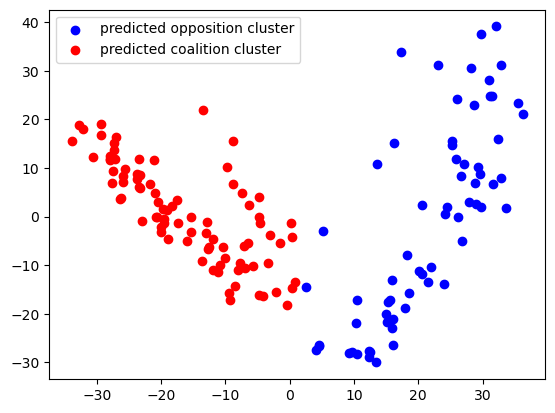

In [141]:
x_tr0 = x_tr[y_pred == 0]
x_tr1 = x_tr[y_pred == 1]

plt.scatter(x_tr0[:,0], x_tr0[:,1], color = 'blue', label = 'predicted opposition cluster')
plt.scatter(x_tr1[:,0], x_tr1[:,1], color = 'red', label = 'predicted coalition cluster')

plt.legend()

In [138]:
term_votes['group'].unique()

coalition = ['TTF','LSDPF','DPF']

coalition_labels = []

for voter_id in voter_ids:
    party = term_votes[term_votes['voter_id'] == voter_id].iloc[0]['group']
    if party in coalition:
        coalition_labels.append(1)
    else:
        coalition_labels.append(0)

coalition_labels = np.array(coalition_labels)

In [139]:
co0 = sum((1-y_pred) * coalition_labels) / sum(1-y_pred) * 100
op0 = 100 - co0
co1 = sum(y_pred * coalition_labels) / sum(y_pred) * 100
op1 = 100 - co1

print(f"{co0}% of MPs in cluster 0 are in the coalition and {op0}% are in opposition")
print(f"{co1}% of MPs in cluster 1 are in the coalition and {op1}% are in opposition")


13.846153846153847% of MPs in cluster 0 are in the coalition and 86.15384615384616% are in opposition
84.88372093023256% of MPs in cluster 1 are in the coalition and 15.116279069767444% are in opposition


In [211]:
comp = pca.components_[0]
print(sum(np.abs(comp) > 1e-2))
print(sum(np.abs(comp) > 3e-2))
print(sum(np.abs(comp) > 5e-2))
print(sum(np.abs(comp) > 7e-2))

deciding_votes = voting_ids[np.abs(comp) > 3e-2]

for deciding_vote in deciding_votes:
    print(term_votes[term_votes['voting_id'] == deciding_vote].iloc[0]['question'])

2578
51
0
0
dėl Seimo nutarimo priėmimo
dėl Lietuvos socialdemokratų partijos frakcijos pasiūlymo išbraukti iš darbotvarkės projektą Nr. XIIP-4237
dėl pritarimo Seimo Pirmininkės L. Graužinienės pasiūlymui baigti neeilinę sesiją
dėl įstatymo priėmimo
dėl 2 straipsnio J. Razmos antros pataisos 
dėl Tėvynės sąjungos-Lietuvos krikščionių demokratų frakcijos pasiūlymo dėl slapto balsavimo
dėl Seimo nutarimo priėmimo
dėl pasiūlymo daryti pertrauką (pagal Seimo statuto 154 straipsnio 3 dalį)
dėl pasiūlymo daryti pertrauką pagal Seimo statuto 158 straipsnio 3 dalį
dėl pasiūlymo daryti pertrauką pagal Seimo statuto 158 straipsnio 3 dalį
dėl pasiūlymo daryti pertrauką pagal Seimo statuto 158 straipsnio 3 dalį
dėl pasiūlymo daryti pertrauką iki kito posėdžio pagal Seimo statuto 109 straipsnį
dėl pasiūlymo priimti šią rezoliuciją be pataisų
dėl Tėvynės sąjungos-Lietuvos krikščionių demokratų frakcijos pasiūlymo išbraukti iš darbotvarkės projektą Nr. XIIP-2841
dėl įstatymo priėmimo
dėl Seimo nutar

In [179]:
predictions = pd.DataFrame(data = {
    'MP': mp_names,
    'group': groups,
    'voter_id': voter_id,
    'in_coalition': coalition_labels,
    'predicted_cluster': y_pred,
    'distance to opposition': km.transform(x_tr)[:,0],
    'distance to coalition': km.transform(x_tr)[:,1],
})

In [20]:
predictions.sort_values('distance to opposition').head(20)

,MP,group,voter_id,in_coalition,predicted_cluster,distance to opposition,distance to coalition
129,Zingeris Emanuelis,TS-LKDF,54.0,0,0,20.663418,41.137024
133,Glaveckas Kęstutis,LSF,54.0,0,0,24.667845,40.928703
143,Kašėta Algis,LSF,54.0,0,0,26.087762,42.356272
116,Kreivys Dainius,TS-LKDF,54.0,0,0,26.537606,50.346384
77,Teišerskytė Dalia,LSF,54.0,0,0,27.019719,46.374554
6,Bilotaitė Agnė,TS-LKDF,54.0,0,0,27.172857,50.085913
120,Saudargas Paulius,TS-LKDF,54.0,0,0,27.355002,50.120941
80,Vareikis Egidijus,TS-LKDF,54.0,0,0,27.553777,48.915811
146,Auštrevičius Petras,LSF,54.0,0,0,27.630007,43.693306
144,Patackas Algirdas Vaclovas,MG,54.0,0,0,27.791817,43.484191


In [32]:
predictions.sort_values('distance to coalition').head(20)

,MP,group,voter_id,in_coalition,predicted_cluster,distance to opposition,distance to coalition
125,Paulauskas Artūras,DPF,54,1,1,42.130287,27.660279
101,Gedvilas Vydas,DPF,54,1,1,44.106436,28.002417
34,Kirkilas Gediminas,LSDPF,54,1,1,38.936905,28.312144
67,Skardžius Artūras,LSDPF,54,1,1,43.626684,29.394324
7,Bradauskas Bronius,LSDPF,54,1,1,41.145443,29.771402
46,Mikolaitis Gintautas,LSDPF,54,1,1,46.795385,30.264978
19,Fiodorovas Viktoras,DPF,54,1,1,48.343295,30.477927
115,Vonžutaitė Vitalija,DPF,54,1,1,40.620698,30.539608
140,Požela Juras,LSDPF,54,1,1,40.413166,30.668420
122,Salamakinas Algimantas,LSDPF,54,1,1,45.729020,30.718938


In [29]:
predictions[predictions['in_coalition'] != predictions['predicted_cluster']]

,MP,group,voter_id,in_coalition,predicted_cluster,distance to opposition,distance to coalition
28,Jedinskij Zbignev,LLRA-KŠSF,54,0,1,55.410083,44.590607
36,Kravčionok Vanda,LLRA-KŠSF,54,0,1,51.948798,44.598688
39,Kvetkovskij Juzef,LLRA-KŠSF,54,0,1,59.327495,48.880401
42,Mackevič Michal,LLRA-KŠSF,54,0,1,59.204865,48.919282
44,Mazuronis Andrius,LSF,54,0,1,48.687074,47.111396
62,Rozova Irina,LLRA-KŠSF,54,0,1,49.248096,39.928656
75,Talmont Leonard,LLRA-KŠSF,54,0,1,49.785664,43.506983
76,Tamašunienė Rita,LLRA-KŠSF,54,0,1,54.354067,44.839720
81,Varkala Jonas,MG,54,0,1,62.816366,60.326991
82,Vasiliauskas Valdas,MG,54,0,1,53.932947,47.748882


# 3. Party-level clustering

In [212]:
groups = term_votes['group'].unique()

In [239]:
n_clusters = 7
kmp = KMeans(n_clusters = n_clusters)

#x_train, x_test = train_test_split(x_tr)
# i'm not sure if train-test-split is necessary...

kmp.fit(x_tr)

y_pred = kmp.predict(x_tr)

predictions['party_cluster'] = y_pred

C:\Users\mykol\.conda\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mykol\.conda\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


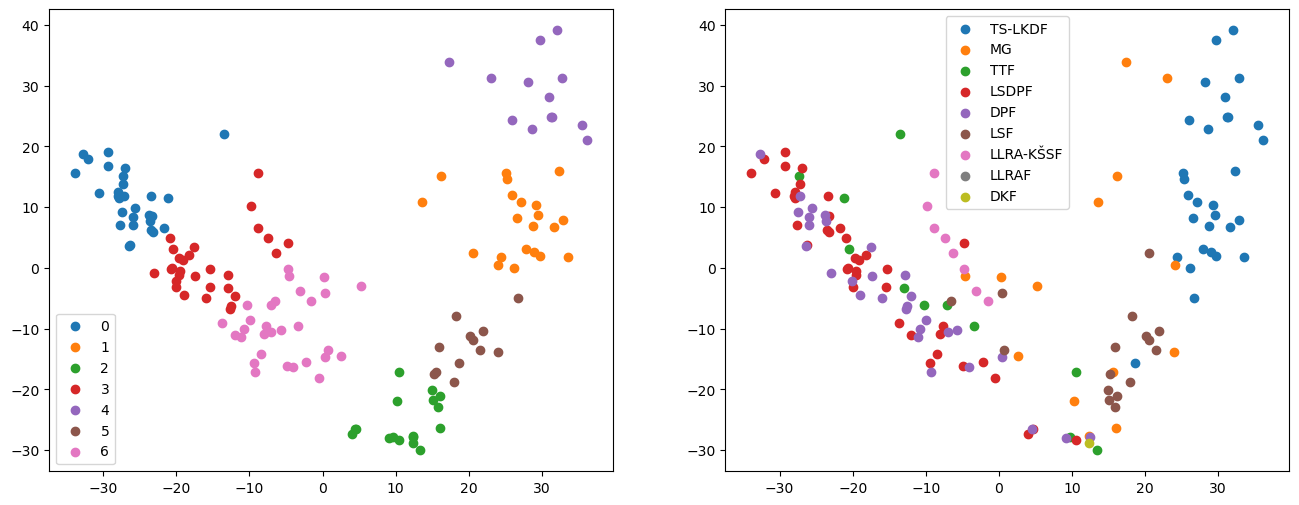

In [240]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 6))
for i in range(n_clusters):
    ax1.scatter(x_tr[y_pred == i,0], x_tr[y_pred == i, 1], label = str(i))
ax1.legend()

for group in term_votes['group'].unique():
    ax2.scatter(x_tr[predictions['group'] == group,0], x_tr[predictions['group'] == group, 1], label = group)
ax2.legend()

In [241]:
predictions[(predictions['group'] == 'TS-LKDF') & (predictions['party_cluster'] == 4)]

,MP,group,voter_id,in_coalition,predicted_cluster,distance to opposition,distance to coalition,party_cluster
11,Dagys Rimantas Jonas,TS-LKDF,54,0,5,28.391678,56.254975,4
27,Jankauskas Donatas,TS-LKDF,54,0,5,25.105608,49.840446,4
30,Jovaiša Sergejus,TS-LKDF,54,0,5,41.637863,61.434628,4
32,Juozapaitis Vytautas,TS-LKDF,54,0,5,27.899224,53.183357,4
38,Kuzminskas Kazimieras,TS-LKDF,54,0,5,34.352509,57.519892,4
43,Matulas Antanas,TS-LKDF,54,0,5,25.839257,48.117740,4
61,Razma Jurgis,TS-LKDF,54,0,5,30.792364,54.365269,4
69,Strelčiūnas Algis,TS-LKDF,54,0,5,32.430012,53.253207,4
70,Stundys Valentinas,TS-LKDF,54,0,5,26.751610,56.018702,4
73,Šedbaras Stasys,TS-LKDF,54,0,5,27.789025,52.989613,4


In [183]:
group = 'TS-LKDF'
for cluster_no in range(n_clusters):
    print(len(predictions[(predictions['party_cluster'] == cluster_no) & (predictions['group'] == group)]) / len(predictions[predictions['group'] == group]))

0.03333333333333333
0.0
0.6
0.0
0.36666666666666664
0.0
0.0
0.0


In [242]:
clc = np.zeros((n_clusters, len(groups)))
for cluster_no in range(n_clusters):
    for j, group in zip(range(len(groups)), groups):
        clc[cluster_no, j] = len(predictions[(predictions['party_cluster'] == cluster_no) & (predictions['group'] == group)]) / len(predictions[predictions['party_cluster'] == cluster_no])

In [243]:
clc = pd.DataFrame(clc, columns = groups, index = [str(i) for i in range(n_clusters)])

clc

,TS-LKDF,MG,TTF,LSDPF,DPF,LSF,LLRA-KŠSF,LLRAF,DKF
0,0.000000,0.000000,0.103448,0.586207,0.310345,0.000000,0.000000,0.0,0.000000
1,0.809524,0.142857,0.000000,0.000000,0.000000,0.047619,0.000000,0.0,0.000000
2,0.000000,0.176471,0.176471,0.176471,0.176471,0.235294,0.000000,0.0,0.058824
3,0.000000,0.000000,0.068966,0.413793,0.344828,0.000000,0.172414,0.0,0.000000
4,0.846154,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5,0.166667,0.166667,0.000000,0.000000,0.000000,0.666667,0.000000,0.0,0.000000
6,0.000000,0.133333,0.100000,0.300000,0.266667,0.100000,0.100000,0.0,0.000000


Each row represents one cluster, specifically the percentage of the cluster that is represented by a certain group.